## setup

In [51]:
from openai import OpenAI, AsyncOpenAI
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, AutoModelForSequenceClassification, DataCollatorForLanguageModeling
from huggingface_hub import login
from dotenv import load_dotenv
from datasets import load_dataset
import torch as t
import asyncio
import os
from peft import LoraConfig, TaskType, get_peft_model
import evaluate
import numpy as np
import bitsandbytes
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML
import wandb
import einops
from peft import LoraConfig, get_peft_model, TaskType
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
load_dotenv()
login(token = os.environ['HF_TOKEN'])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## FT Dataset

### Load Dataset

In [3]:
def get_dataset(lang):
    dataset = load_dataset('iNeil77/CodeNet', lang, split='train')
    dataset = dataset.select_columns(['p_id', 'language', 'status', 'code'])
    dataset = dataset.filter(lambda x: x['status']=='Accepted')
    return dataset

my_dataset = get_dataset('Java')

In [4]:
# for i in range(10):
#     idx = random.randint(0, dataset_cpp.num_rows)
#     code = dataset_cpp[idx]['code']
#     print(code)
#     print('--x---x---x--\n')

### Fine-tune

In [54]:
model_name = 'meta-llama/Llama-3.1-8B-Instruct'
tokenizer = AutoTokenizer.from_pretrained(model_name, pad_side="left")
model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    device_map="auto", 
    torch_dtype="auto"
    # load_in_4bit=True, 
    # bnb_4bit_compute_dtype=t.bfloat16,
)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [56]:
seq_lengths = []
test = True

def tokenize(record):
    global test

    code = record['code']
    tokens = tokenizer(
        code, 
        truncation=True,
        max_length=1024,
    )

    tokseq = tokens['input_ids']
    for toks in tokseq:
        seq_lengths.append(len(toks))

    # seq_lengths.append(len(tokens['input_ids']))
    return tokens

tokenized_dataset = my_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/348362 [00:00<?, ? examples/s]

In [58]:
import json
with open('seq_lengths.json', 'w') as f:
    json.dump(seq_lengths, f)

In [52]:
sum(seq_lengths) / len(seq_lengths)

342.11280794116465

(array([10302., 44000., 47714., 37685., 30091., 21539., 16306., 12920.,
        10868.,  8993.,  7649.,  6659.,  5930.,  5057.,  4309.,  4135.,
         3755.,  3681.,  3358.,  3254.,  3258.,  3075.,  2893.,  2727.,
         2528.,  2416.,  2048.,  1929.,  1782., 37501.]),
 array([  27.        ,   60.23333333,   93.46666667,  126.7       ,
         159.93333333,  193.16666667,  226.4       ,  259.63333333,
         292.86666667,  326.1       ,  359.33333333,  392.56666667,
         425.8       ,  459.03333333,  492.26666667,  525.5       ,
         558.73333333,  591.96666667,  625.2       ,  658.43333333,
         691.66666667,  724.9       ,  758.13333333,  791.36666667,
         824.6       ,  857.83333333,  891.06666667,  924.3       ,
         957.53333333,  990.76666667, 1024.        ]),
 <BarContainer object of 30 artists>)

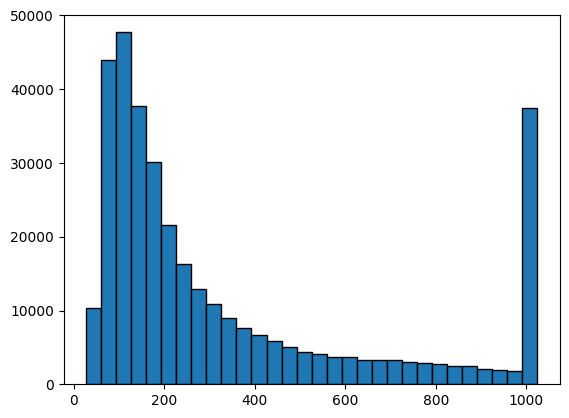

In [53]:
plt.hist(seq_lengths, bins=30, edgecolor='black')

In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],  # Adjust for Llama 3.1 if needed
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

In [ ]:
training_args = TrainingArguments(
    output_dir="./llama3-java-finetune",
    per_device_train_batch_size=4,  # Adjust based on GPU memory
    gradient_accumulation_steps=8,
    num_train_epochs=1,  
    learning_rate=2e-4,
    bf16=True,
    save_steps=1000,
    logging_steps=100,
    report_to="wandb"
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # For causal LM
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [ ]:
trainer.train()


## Un-Focus

### HuggingFace Finetuning 

In [ ]:
dataset = load_dataset("karpathy/tiny_shakespeare")
print(dataset)
# print('hlelow')

In [ ]:
model_name = 'meta-llama/Llama-3.1-8B-Instruct'
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_size='left')
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_8bit=True,  # Optional: saves memory
    device_map="auto",
    # torch_dtype="auto"
)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
questions = [
    'What is 5+5?', 
    'Tell me a poem.',
    'Tell me a story.',
]
message_template = [
    {"role": "system", "content": "You are a friendly, helpful chatbot."},
    {"role": "user", "content": ''},
]

def qualitative_eval():
    out = []
    for question in questions:
        message = message_template
        message[1]['content'] = question

        model_inputs = tokenizer.apply_chat_template(message, add_generation_prompt=True, return_tensors='pt').to('cuda')
        generated_ids = model.generate(model_inputs, do_sample=True, max_new_tokens=50)
        text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].split('assistant')[-1]

        out.append(text)
    
    return out

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    num_proc=4,
    remove_columns=["text"]
)

In [ ]:
block_size = 256

def group_texts(examples):
    concatenated = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated["input_ids"])
    total_length = (total_length // block_size) * block_size
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

lm_dataset = tokenized_dataset.map(
    group_texts,
    batched=True,
    num_proc=4
)

In [ ]:
training_args = TrainingArguments(
    output_dir="./llama3-shakespeare",
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    learning_rate=2e-4,
    bf16=True,
    logging_steps=10,
    save_steps=100,
    save_total_limit=2,
)

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, lora_config)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["validation"],
    tokenizer=tokenizer
)

trainer.train()

In [ ]:
qualitative_eval()

In [ ]:
trainer.save_model("./llama3-shakespeare")
tokenizer.save_pretrained("./llama3-shakespeare")

### HuggingFace Training (0/2)

In [ ]:
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')
datasets['train']['text']

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"]).to('cuda')

model_checkpoint = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

In [ ]:
block_size = tokenizer.model_max_length

first = True
my_result = ...
counter = 0

def group_texts(examples):
    global my_result, counter, first

    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size

    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()

    counter += 1
    if first:
        my_result = result
        first = False

    return result

In [ ]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    # num_proc=4,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_checkpoint, device_map='auto', torch_dtype='auto')

model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    f"{model_name}-finetuned-wikitext2",
    eval_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
)

In [ ]:
trainer.train()

### HuggingFace Training (2/2)

In [ ]:
model_name = 'meta-llama/Llama-3.1-8B-Instruct'
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(model_name, device_map='auto', torch_dtype='auto')
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
questions = [
    'What is 5+5?', 
    'Tell me a poem.',
    'Tell me a story.',
]
message_template = [
    {"role": "system", "content": "You are a friendly, helpful chatbot."},
    {"role": "user", "content": ''},
]

def qualitative_eval():
    out = []
    for question in questions:
        message = message_template
        message[1]['content'] = question

        model_inputs = tokenizer.apply_chat_template(message, add_generation_prompt=True, return_tensors='pt').to('cuda')
        generated_ids = model.generate(model_inputs, do_sample=True, max_new_tokens=50)
        text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].split('assistant')[-1]

        out.append(text)
    
    return out

out = qualitative_eval()
# for sentence in out:
#     print(sentence)

In [ ]:
def tokenize(text):
    return tokenizer(text['text'])

dataset = load_dataset('karpathy/tiny_shakespeare', trust_remote_code=True)
tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns='text')

In [ ]:
block_size = 1028

def group_text(input):
    length = len(input['input_ids'])
    n_batches = length // block_size

    result = dict()

    for k, t in input.items():
        t = np.array(t[:n_batches * block_size])
        t = einops.rearrange(t, '(bat block) -> bat block', bat=n_batches)
        t = t.tolist()

        result[k] = t

    result['labels'] = result['input_ids'].copy()
    return result

lm_dataset = tokenized_dataset.map(group_text)

In [ ]:
training_args = TrainingArguments(
    f"finetuned-tiny-shakespeare",
    eval_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["validation"],
)

In [ ]:
trainer.train()

### HuggingFace Training (1/2)

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-3.1-8B-Instruct', padding_side='left')
# model = AutoModelForCausalLM.from_pretrained('meta-llama/Llama-3.1-8B-Instruct', device_map='auto', torch_dtype='auto')
# tokenizer.pad_token = tokenizer.eos_token

In [ ]:
ft_dataset = load_dataset('yelp_review_full')
ft_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-cased')

def tokenize(examples):
    return ft_tokenizer(examples["text"], padding="max_length", truncation=True).to('cuda')
dataset = ft_dataset.map(tokenize, batched=True)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)


In [ ]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="yelp_review_classifier",
    eval_strategy="epoch",
)

In [ ]:
small_train = dataset["train"].shuffle(seed=42).select(range(1000))
small_eval = dataset["test"].shuffle(seed=42).select(range(1000))

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_eval,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

### HuggingFace Practice  
*getting comfortable with HF*

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-3.1-8B-Instruct', padding_side="left")
model = AutoModelForCausalLM.from_pretrained(
        'meta-llama/Llama-3.1-8B-Instruct', 
        device_map = 'auto',
        torch_dtype = 'auto',
)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
sentences = [
    'Jack n jill went up the hill to smoke a lot of pot',
    'Beautiful world, where are you?',
    'In the beginning, the universe was created. This was widely regarded as a bad move.',
]

out = tokenizer(sentences, padding=True, return_tensors='pt')['input_ids']


out2 = tokenizer.decode(out[0])

out3 = tokenizer.batch_decode(out, skip_special_tokens=True)

print(out2 + '\n')
print(out)

out3

In [ ]:
test_sentence = "What is 5+5? Reply with a single word."
model_inputs = tokenizer(test_sentence, return_tensors='pt').to('cuda')

generated = model.generate(**model_inputs, max_new_tokens=100, temperature=0.3, repetition_penalty= 2.0)
out = tokenizer.batch_decode(generated)

In [ ]:
print(out[0])

In [ ]:
model.generation_config

In [ ]:
messages = [
    {
        "role": "system",
        "content": "You are a friendly, helpful chatbot.",
    },
    {"role": "user", "content": "What is 5+5? Answer with a single word."},
]

model_inputs = tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt").to("cuda")
generated_ids = model.generate(model_inputs, do_sample=True, max_new_tokens=50)
print(tokenizer.batch_decode(generated_ids)[0])



### LoRA

In [ ]:
model

In [ ]:
# create LoRA configuration object
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, # type of task to train on
    inference_mode=False, # set to False for training
    r=8, 
    lora_alpha=32, 
    lora_dropout=0.1,
)

In [ ]:
model.add_adapter(lora_config, adapter_name="lora_1")


In [ ]:
model

### Async Test

In [ ]:
async def task1():
    print("Task 1: Start")
    await asyncio.sleep(2)
    print("Task 1: End")

async def task2():
    print("Task 2: Start")
    await asyncio.sleep(1)
    print("Task 2: End")

# async def main():
await asyncio.gather(task1(), task2())

# await main()

In [ ]:
async def chat_async():
    prompt = 'hello world'
    client = AsyncOpenAI()

    response = await client.responses.create(
        model = 'gpt-4.1-mini',
        input = prompt,
    )

    text_out = response.output[-1].content[0].text
    return text_out

def chat_reg():
    prompt = 'hello world'
    client = OpenAI()

    response = client.responses.create(
        model = 'gpt-4.1-mini',
        input = prompt,
    )

    text_out = response.output[-1].content[0].text
    return text_out

In [ ]:
await chat_async()